# Hotel Booking Cancellation Prediction
## Modeling

### **Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
import seaborn as sns
sns.set_theme(style="darkgrid")
import os
import time
import pickle
from datetime import datetime

from sklearn import __version__ as sklearn_version
from scipy.stats import uniform
from random import sample
np.random.seed(123)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import make_pipeline

### **Loading Data**

In [ ]:
# mounting the drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# loading the preprocessed dataset
working_dir = "/content/drive/MyDrive/hotel-booking-cancellation-prediction/data/"
hotels = pd.read_csv(working_dir + "interim/hotels_for_modeling.csv", index_col=0)

In [ ]:
hotels['cust_segmentation'] = hotels['cust_segmentation'].astype('str')
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119389 entries, 0 to 119388
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119389 non-null  object 
 1   is_canceled                     119389 non-null  int64  
 2   lead_time                       119389 non-null  int64  
 3   arrival_date_year               119389 non-null  int64  
 4   arrival_date_month              119389 non-null  int64  
 5   arrival_date_week_number        119389 non-null  int64  
 6   arrival_date_day_of_month       119389 non-null  int64  
 7   stays_in_weekend_nights         119389 non-null  int64  
 8   stays_in_week_nights            119389 non-null  int64  
 9   adults                          119389 non-null  int64  
 10  children                        119389 non-null  float64
 11  babies                          119389 non-null  int64  
 12  meal            

In [ ]:
X = hotels.drop('is_canceled', axis=1)
y = hotels['is_canceled']
X.shape, y.shape

((119389, 31), (119389,))

In [ ]:
X.columns

Index(['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'booking_changes', 'deposit_type', 'agent', 'company',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'arrival_day_of_week', 'booking_purpose', 'received_different_room',
       'cust_segmentation'],
      dtype='object')

In [ ]:
X_dumm = pd.get_dummies(X, drop_first=True)
X_dumm.shape

(119389, 62)

In [ ]:
X.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,arrival_day_of_week,booking_purpose,received_different_room,cust_segmentation
0,Resort Hotel,342,2015,7,27,1,0,0,2,0.0,...,no_company,0,Transient,0.0,0,0,2,short_stay,0,0
1,Resort Hotel,737,2015,7,27,1,0,0,2,0.0,...,no_company,0,Transient,0.0,0,0,2,short_stay,0,0
2,Resort Hotel,7,2015,7,27,1,0,1,1,0.0,...,no_company,0,Transient,75.0,0,0,2,business,1,0
3,Resort Hotel,13,2015,7,27,1,0,1,1,0.0,...,no_company,0,Transient,75.0,0,0,2,business,0,1
4,Resort Hotel,14,2015,7,27,1,0,2,2,0.0,...,no_company,0,Transient,98.0,0,1,2,business,0,3


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dumm, y, test_size = 0.3)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# plotting the ROC curve
def plot_ROC(model):
        global train_roc_score, test_roc_score

        y_pred_prob = model.predict_proba(X_test)[:,1]
        y_tr_pred_prob = model.predict_proba(X_train)[:,1]

        train_roc_score = round(roc_auc_score(y_train, y_tr_pred_prob),4)
        test_roc_score = round(roc_auc_score(y_test, y_pred_prob),4)

        print('Train - Area under ROC score: {}'.format(train_roc_score))
        print('Test - Area under ROC score: {}'.format(test_roc_score))

        fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_prob)
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_tr_pred_prob)
        plt.figure(figsize=(6,6))
        plt.plot(fpr_test, tpr_test, label = 'Test ROC', c = 'r')
        plt.plot(fpr_train, tpr_train, label = 'Train ROC', c = 'blue')
        plt.xlabel('True Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.title('{} ROC Curve'.format(model))


        plt.show()

In [ ]:
def evaluation_block(model):
    global train_acc, test_acc

    y_tr_pred = model.predict(X_train)

    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)

    print("Train - Accuracy:", train_acc)
    print("Test - Accuracy:", test_acc)
    print('Validation - Classification report\n', classification_report(y_test,y_pred))
    plt.figure(figsize=(9,9))
    # plot_confusion_matrix(model, X_test, y_test, normalize='true', cmap = 'Blues')
    plt.show()

In [ ]:
results = pd.DataFrame(columns = ['model','train_accuracy', 'test_accuracy', 'train_ROC', 'test_ROC'])
pd.set_option("max_colwidth", 100)
def save_scores(model):

    new_row = {'model':model,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_ROC': train_roc_score,
               'test_ROC': test_roc_score}
    results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row

In [ ]:
logreg = LogisticRegression(max_iter = 10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
evaluation_block(logreg)

Train - Accuracy: 0.8211
Test - Accuracy: 0.8223
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.66      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.8761
Test - Area under ROC score: 0.8764


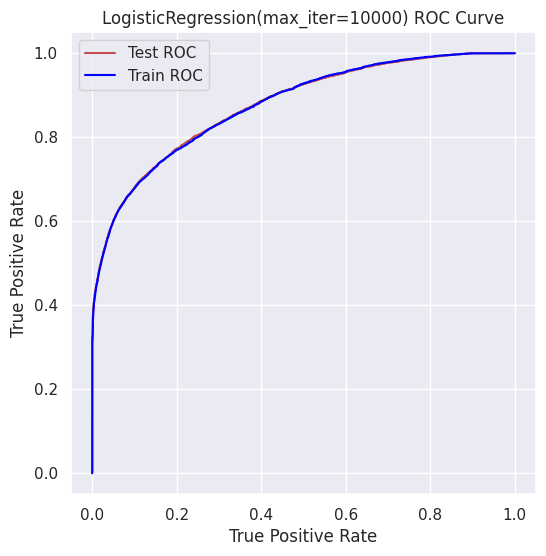

In [ ]:
plot_ROC(logreg)

The score for the out of the box LogisticRegression model is: 0.8224 accuracy and 0.8765 AUROC score.

In [ ]:
save_scores(logreg)

In [ ]:
pca = PCA()
pca.fit(X_train)

PCA()

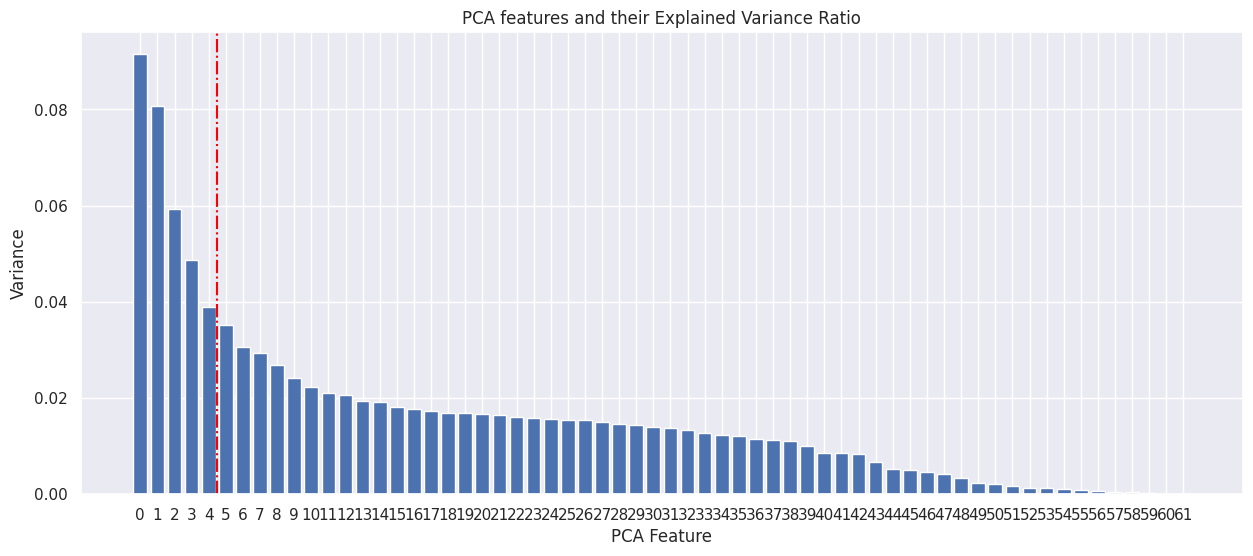

In [ ]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.axvline(4.5, c = 'red', linestyle = '-.')
plt.xticks(features)
plt.ylabel('Variance')
plt.xlabel('PCA Feature')
plt.title('PCA features and their Explained Variance Ratio')
plt.show()

Text(0.5, 1.0, 'Cummulative PCA features with a 50%, 70% 90% and 99% explained variance ratio thresholds" ')

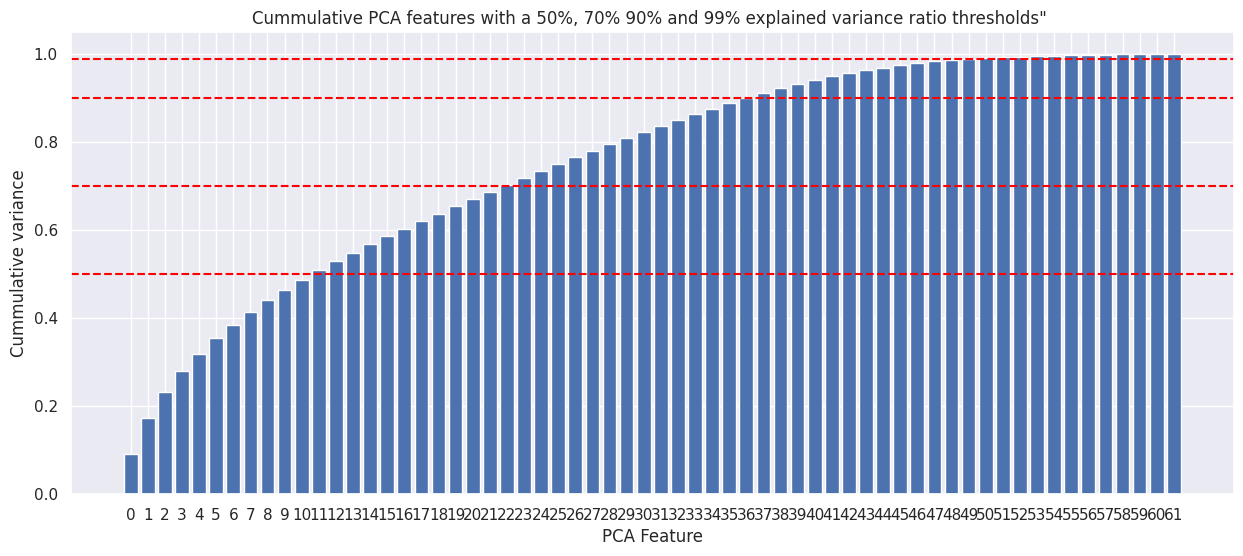

In [ ]:
plt.bar(features, np.cumsum(pca.explained_variance_ratio_))
[plt.axhline(y=i, linestyle='--', c = 'red') for i in [.5,.7,.9, 0.99]]
plt.xticks(features)
plt.ylabel('Cummulative variance')
plt.xlabel('PCA Feature')
plt.title('Cummulative PCA features with a 50%, 70% 90% and 99% explained variance ratio thresholds" ')

In [ ]:
pca_feat = [5,11,22,37,50]
for i in pca_feat:
    pca = PCA(n_components = i)
    pca.fit(X_train)
    X_train_i = pca.transform(X_train)
    X_test_i = pca.transform(X_test)

    logreg_model = LogisticRegression(max_iter=10000)
    logreg_model.fit(X_train_i, y_train)

    y_tr_pred = logreg_model.predict(X_train_i)
    y_tr_pred_prob = logreg_model.predict_proba(X_train_i)[:,1]

    y_pred = logreg_model.predict(X_test_i)
    y_pred_prob = logreg_model.predict_proba(X_test_i)[:,1]


    print('---------------------Train & Test scores : Log reg model with {} PCA features-------------------'.format(i))
    print('Train - Accuracy: ', round(accuracy_score(y_train,y_tr_pred),4))
    print('Test - Accuracy: ', round(accuracy_score(y_test,y_pred),4))
    print('Train - Area under ROC score: {} '.format(round(roc_auc_score(y_train, y_tr_pred_prob),4)))
    print('Test - Area under ROC score: {} \n'.format(round(roc_auc_score(y_test, y_pred_prob),4)))
    print(classification_report(y_test,y_pred))
    plt.figure(figsize=(9,9))
    # plot_confusion_matrix(logreg_model, X_test_i, y_test, normalize='true', cmap = 'Blues')
    plt.show()

---------------------Train & Test scores : Log reg model with 5 PCA features-------------------
Train - Accuracy:  0.6644
Test - Accuracy:  0.6689
Train - Area under ROC score: 0.6636 
Test - Area under ROC score: 0.6609 

              precision    recall  f1-score   support

           0       0.68      0.91      0.78     22691
           1       0.62      0.26      0.36     13126

    accuracy                           0.67     35817
   macro avg       0.65      0.58      0.57     35817
weighted avg       0.66      0.67      0.62     35817



<Figure size 900x900 with 0 Axes>

---------------------Train & Test scores : Log reg model with 11 PCA features-------------------
Train - Accuracy:  0.7687
Test - Accuracy:  0.7726
Train - Area under ROC score: 0.8146 
Test - Area under ROC score: 0.8143 

              precision    recall  f1-score   support

           0       0.77      0.92      0.84     22691
           1       0.79      0.52      0.63     13126

    accuracy                           0.77     35817
   macro avg       0.78      0.72      0.73     35817
weighted avg       0.78      0.77      0.76     35817



<Figure size 900x900 with 0 Axes>

---------------------Train & Test scores : Log reg model with 22 PCA features-------------------
Train - Accuracy:  0.7929
Test - Accuracy:  0.7947
Train - Area under ROC score: 0.8397 
Test - Area under ROC score: 0.8402 

              precision    recall  f1-score   support

           0       0.79      0.92      0.85     22691
           1       0.80      0.59      0.68     13126

    accuracy                           0.79     35817
   macro avg       0.80      0.75      0.76     35817
weighted avg       0.80      0.79      0.79     35817



<Figure size 900x900 with 0 Axes>

---------------------Train & Test scores : Log reg model with 37 PCA features-------------------
Train - Accuracy:  0.809
Test - Accuracy:  0.8099
Train - Area under ROC score: 0.8658 
Test - Area under ROC score: 0.8666 

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     22691
           1       0.79      0.65      0.71     13126

    accuracy                           0.81     35817
   macro avg       0.81      0.78      0.79     35817
weighted avg       0.81      0.81      0.81     35817



<Figure size 900x900 with 0 Axes>

---------------------Train & Test scores : Log reg model with 50 PCA features-------------------
Train - Accuracy:  0.821
Test - Accuracy:  0.8229
Train - Area under ROC score: 0.8739 
Test - Area under ROC score: 0.8743 

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.83      0.65      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 900x900 with 0 Axes>

In [ ]:
c_space = np.logspace(-4, 2, 10)
param_grid = {'C': c_space}

logreg_cv = GridSearchCV(logreg, param_grid, cv = 5)
logreg_cv.fit(X_train, y_train)
y_pred = logreg_cv.predict(X_test)

print('Logistic Regression(with GridSearch CV) Parameters: ', logreg_cv.best_params_)
print('Logistic Regression(with GridSearch CV) best score: ', logreg_cv.best_score_)

print('\n')

Logistic Regression(with GridSearch CV) Parameters:  {'C': 100.0}
Logistic Regression(with GridSearch CV) best score:  0.82059787415824




In [ ]:
evaluation_block(logreg_cv)

Train - Accuracy: 0.8212
Test - Accuracy: 0.8222
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.66      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.8762
Test - Area under ROC score: 0.8765


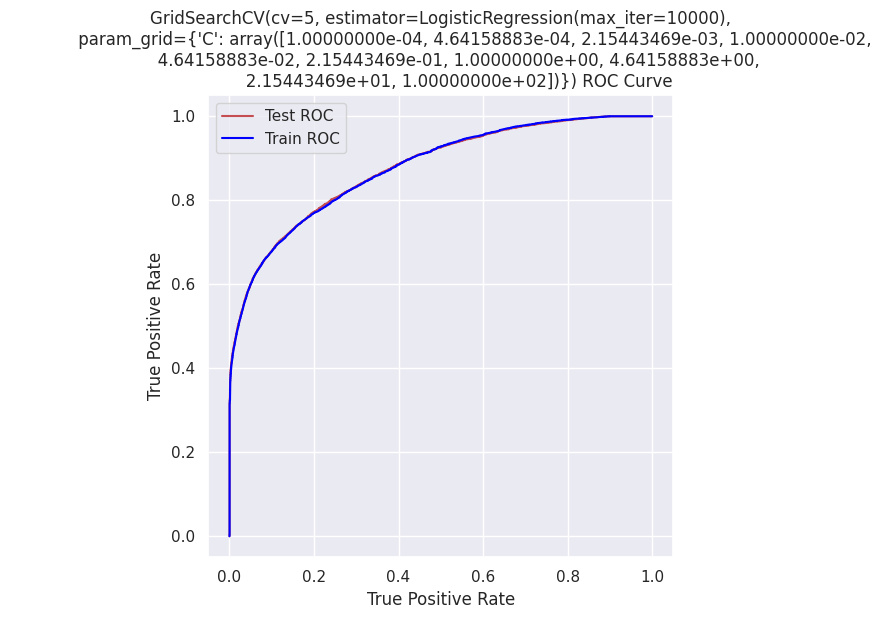

In [ ]:
plot_ROC(logreg_cv)

In [ ]:
save_scores(logreg_cv)

In [ ]:
params_dist = dict(C=uniform(loc=0, scale=5))

logreg_r_cv = RandomizedSearchCV(logreg, params_dist)
logreg_r_cv.fit(X_train, y_train)
y_pred = logreg_r_cv.predict(X_test)

print('Logistic Regression(with Randomized CV) Parameters: ', logreg_r_cv.best_params_)
print('Logistic Regression(with Randomized CV) best score: ', logreg_r_cv.best_score_)

print('\n')

Logistic Regression(with Randomized CV) Parameters:  {'C': 3.3821756585560117}
Logistic Regression(with Randomized CV) best score:  0.8205978705788155




In [ ]:
evaluation_block(logreg_r_cv)

Train - Accuracy: 0.8211
Test - Accuracy: 0.822
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.92      0.87     22691
           1       0.82      0.66      0.73     13126

    accuracy                           0.82     35817
   macro avg       0.82      0.79      0.80     35817
weighted avg       0.82      0.82      0.82     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.8761
Test - Area under ROC score: 0.8765


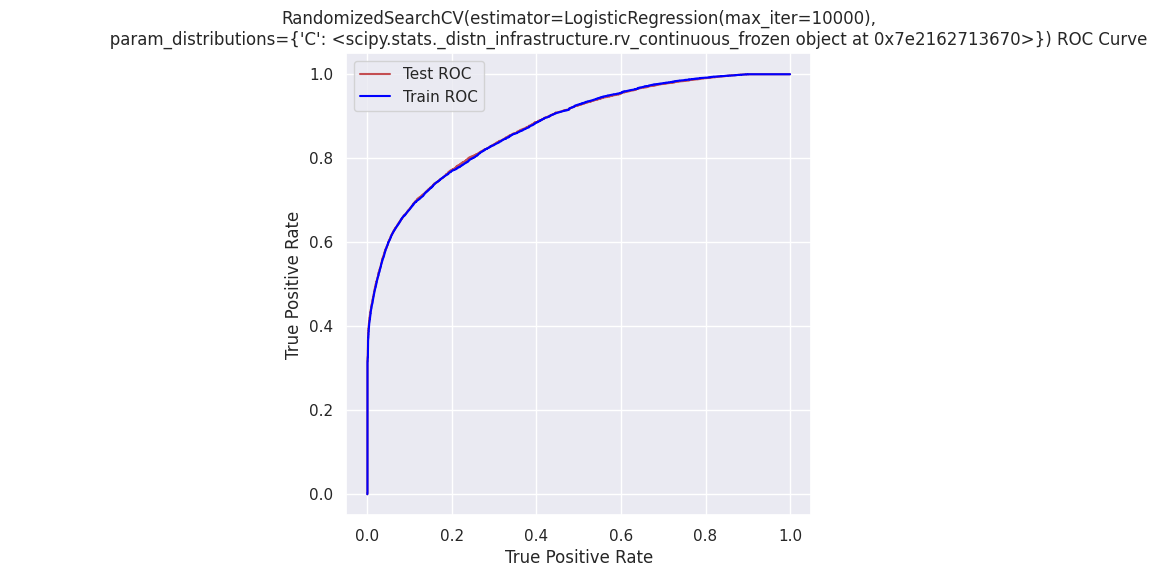

In [ ]:
plot_ROC(logreg_r_cv)

In [ ]:
results.sort_values('test_accuracy', ascending = False)

,model,train_accuracy,test_accuracy,train_ROC,test_ROC
0,LogisticRegression(max_iter=10000),0.8211,0.8223,0.8761,0.8764
1,LogisticRegression(max_iter=10000),0.8211,0.8223,0.8761,0.8764
2,"GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000),\n param_grid={'C': ...",0.8212,0.8222,0.8762,0.8765


---------------Test scores : KNeighborsClassifier model with 2 neighbors--------------
Test - Accuracy:  0.8287
Test - Area under ROC score: 0.8509 

295.455196067 seconds
---------------Test scores : KNeighborsClassifier model with 3 neighbors--------------
Test - Accuracy:  0.824
Test - Area under ROC score: 0.8703 

292.12687296299987 seconds
---------------Test scores : KNeighborsClassifier model with 6 neighbors--------------
Test - Accuracy:  0.8287
Test - Area under ROC score: 0.8853 

294.61512946899984 seconds
---------------Test scores : KNeighborsClassifier model with 7 neighbors--------------
Test - Accuracy:  0.8268
Test - Area under ROC score: 0.8878 

291.2388455549999 seconds
---------------Test scores : KNeighborsClassifier model with 10 neighbors--------------
Test - Accuracy:  0.829
Test - Area under ROC score: 0.8906 

293.6639933900001 seconds
---------------Test scores : KNeighborsClassifier model with 11 neighbors--------------
Test - Accuracy:  0.8278
Test - Are

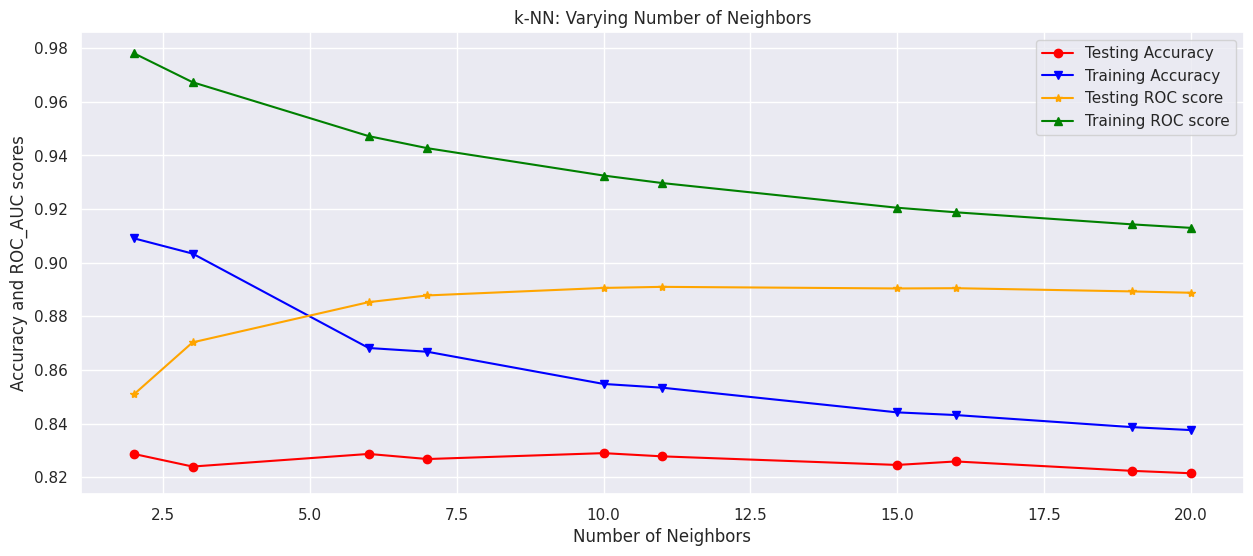

In [ ]:
no_neighbors = (2,3,6,7,10,11,15,16,19,20)
train_accuracy = np.empty(len(no_neighbors))
test_accuracy = np.empty(len(no_neighbors))
train_ROC = np.empty(len(no_neighbors))
test_ROC = np.empty(len(no_neighbors))

for i, k in enumerate(no_neighbors):
    start = time.process_time()
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)

    y_pred = knn.predict(X_test)
    y_pred_prob = knn.predict_proba(X_test)[:,1]

    y_tr_pred = knn.predict(X_train)
    y_tr_pred_prob = knn.predict_proba(X_train)[:,1]


    train_roc_score = round(roc_auc_score(y_train, y_tr_pred_prob),4)
    test_roc_score = round(roc_auc_score(y_test, y_pred_prob),4)
    train_acc = round(accuracy_score(y_train,y_tr_pred),4)
    test_acc = round(accuracy_score(y_test,y_pred),4)

    train_accuracy[i] = train_acc
    test_accuracy[i] = test_acc
    train_ROC[i] = train_roc_score
    test_ROC[i] = test_roc_score

    save_scores(knn)

    print('---------------Test scores : KNeighborsClassifier model with {} neighbors--------------'.format(k))
    print('Test - Accuracy: ', round(accuracy_score(y_test,y_pred),4))
    print('Test - Area under ROC score: {} \n'.format(round(roc_auc_score(y_test, y_pred_prob),4)))

    print(time.process_time() - start, 'seconds')

plt.title('k-NN: Varying Number of Neighbors')
plt.plot(no_neighbors, test_accuracy, label = 'Testing Accuracy', marker = 'o', c = 'red')
plt.plot(no_neighbors, train_accuracy, label = 'Training Accuracy', marker = 'v', c = 'blue')
plt.plot(no_neighbors, test_ROC, label = 'Testing ROC score', marker = '*', c = 'orange')
plt.plot(no_neighbors, train_ROC, label = 'Training ROC score', marker = '^', c = 'green')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy and ROC_AUC scores')
plt.show()

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [ ]:
evaluation_block(rfc)

Train - Accuracy: 0.9922
Test - Accuracy: 0.8716
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     22691
           1       0.87      0.77      0.81     13126

    accuracy                           0.87     35817
   macro avg       0.87      0.85      0.86     35817
weighted avg       0.87      0.87      0.87     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9991
Test - Area under ROC score: 0.9373


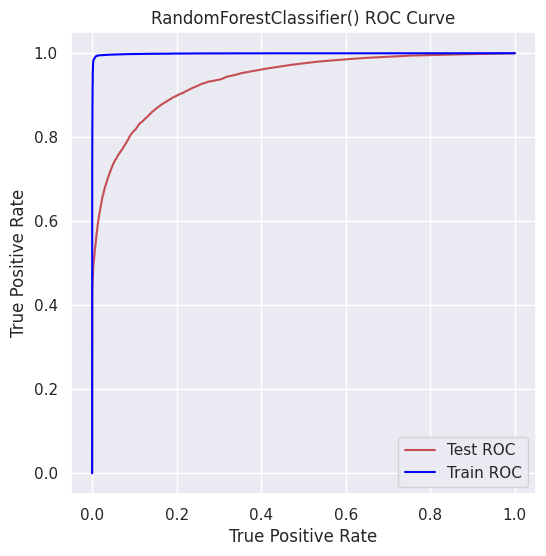

In [ ]:
plot_ROC(rfc)

In [ ]:
save_scores(rfc)

---------Train & Test scores : RFC model with n_estimators = 50 and max_depth = 10 ---------
Train - Accuracy: 0.8257
Test - Accuracy: 0.8238
Validation - Classification report
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     22691
           1       0.90      0.58      0.71     13126

    accuracy                           0.82     35817
   macro avg       0.85      0.77      0.79     35817
weighted avg       0.84      0.82      0.81     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.908
Test - Area under ROC score: 0.9006


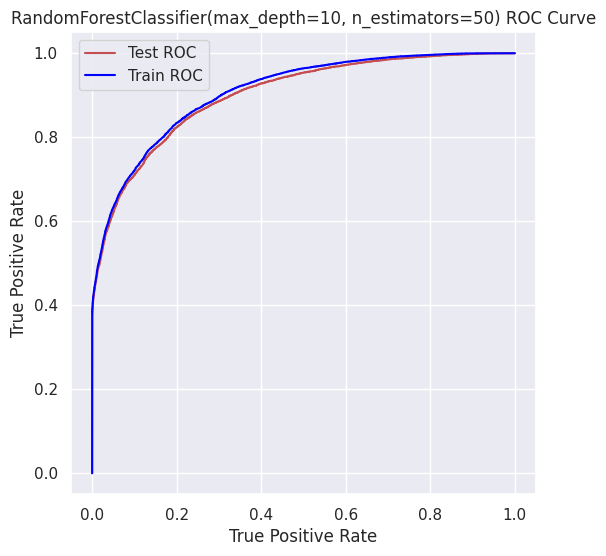

---------Train & Test scores : RFC model with n_estimators = 100 and max_depth = 10 ---------
Train - Accuracy: 0.8257
Test - Accuracy: 0.8247
Validation - Classification report
               precision    recall  f1-score   support

           0       0.80      0.97      0.87     22691
           1       0.91      0.58      0.71     13126

    accuracy                           0.82     35817
   macro avg       0.85      0.77      0.79     35817
weighted avg       0.84      0.82      0.81     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9091
Test - Area under ROC score: 0.9016


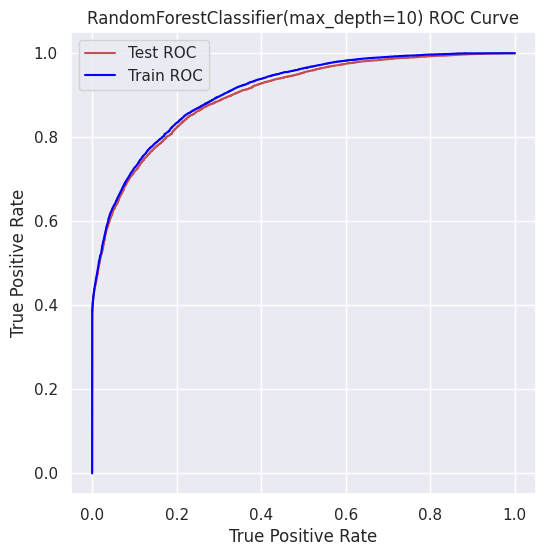

---------Train & Test scores : RFC model with n_estimators = 200 and max_depth = 10 ---------
Train - Accuracy: 0.8256
Test - Accuracy: 0.8242
Validation - Classification report
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     22691
           1       0.90      0.59      0.71     13126

    accuracy                           0.82     35817
   macro avg       0.85      0.77      0.79     35817
weighted avg       0.84      0.82      0.81     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9098
Test - Area under ROC score: 0.9024


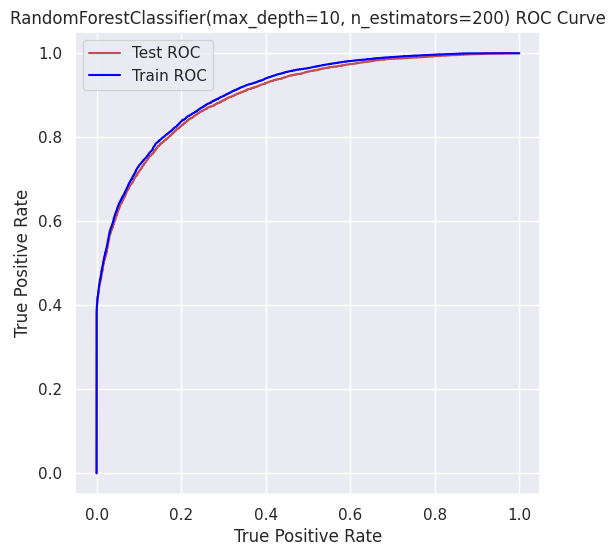

---------Train & Test scores : RFC model with n_estimators = 50 and max_depth = 20 ---------
Train - Accuracy: 0.9048
Test - Accuracy: 0.8602
Validation - Classification report
               precision    recall  f1-score   support

           0       0.85      0.94      0.90     22691
           1       0.88      0.72      0.79     13126

    accuracy                           0.86     35817
   macro avg       0.87      0.83      0.84     35817
weighted avg       0.86      0.86      0.86     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9772
Test - Area under ROC score: 0.9303


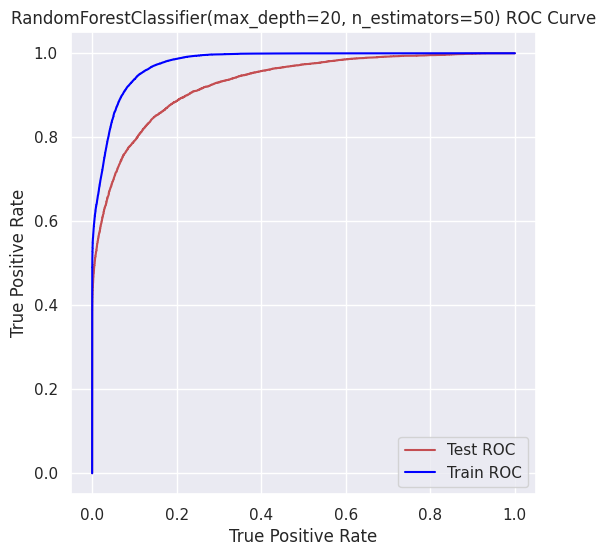

---------Train & Test scores : RFC model with n_estimators = 100 and max_depth = 20 ---------
Train - Accuracy: 0.9048
Test - Accuracy: 0.8607
Validation - Classification report
               precision    recall  f1-score   support

           0       0.85      0.94      0.90     22691
           1       0.88      0.72      0.79     13126

    accuracy                           0.86     35817
   macro avg       0.87      0.83      0.84     35817
weighted avg       0.86      0.86      0.86     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9773
Test - Area under ROC score: 0.9314


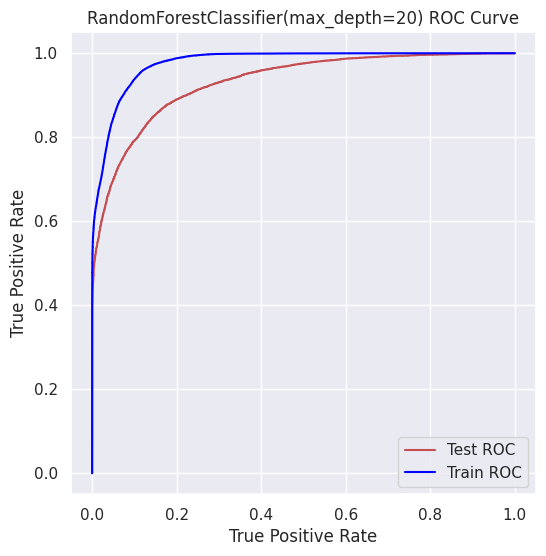

---------Train & Test scores : RFC model with n_estimators = 200 and max_depth = 20 ---------
Train - Accuracy: 0.9053
Test - Accuracy: 0.8607
Validation - Classification report
               precision    recall  f1-score   support

           0       0.85      0.94      0.90     22691
           1       0.88      0.72      0.79     13126

    accuracy                           0.86     35817
   macro avg       0.87      0.83      0.84     35817
weighted avg       0.86      0.86      0.86     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9775
Test - Area under ROC score: 0.9323


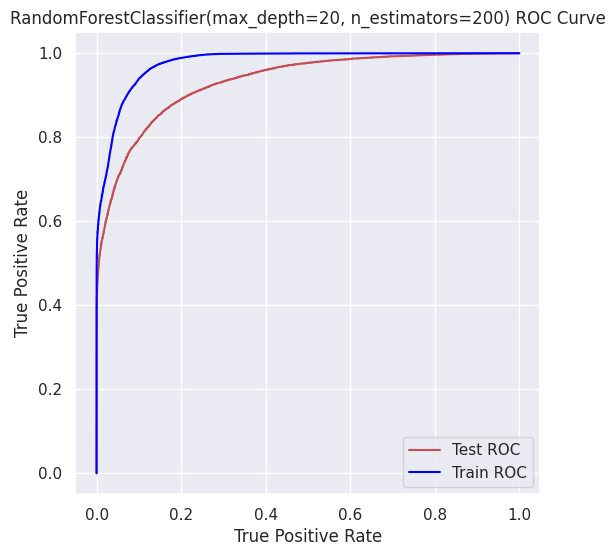

---------Train & Test scores : RFC model with n_estimators = 50 and max_depth = None ---------
Train - Accuracy: 0.992
Test - Accuracy: 0.8714
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     22691
           1       0.87      0.77      0.81     13126

    accuracy                           0.87     35817
   macro avg       0.87      0.85      0.86     35817
weighted avg       0.87      0.87      0.87     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9991
Test - Area under ROC score: 0.9354


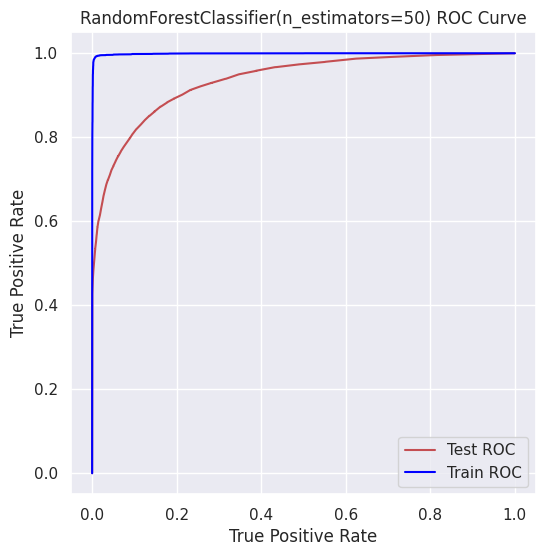

---------Train & Test scores : RFC model with n_estimators = 100 and max_depth = None ---------
Train - Accuracy: 0.9922
Test - Accuracy: 0.872
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     22691
           1       0.87      0.77      0.81     13126

    accuracy                           0.87     35817
   macro avg       0.87      0.85      0.86     35817
weighted avg       0.87      0.87      0.87     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9991
Test - Area under ROC score: 0.9365


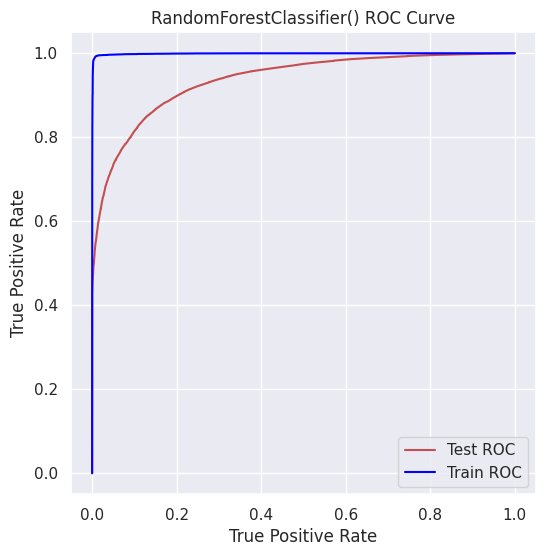

---------Train & Test scores : RFC model with n_estimators = 200 and max_depth = None ---------
Train - Accuracy: 0.9922
Test - Accuracy: 0.8722
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     22691
           1       0.87      0.77      0.81     13126

    accuracy                           0.87     35817
   macro avg       0.87      0.85      0.86     35817
weighted avg       0.87      0.87      0.87     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9991
Test - Area under ROC score: 0.9378


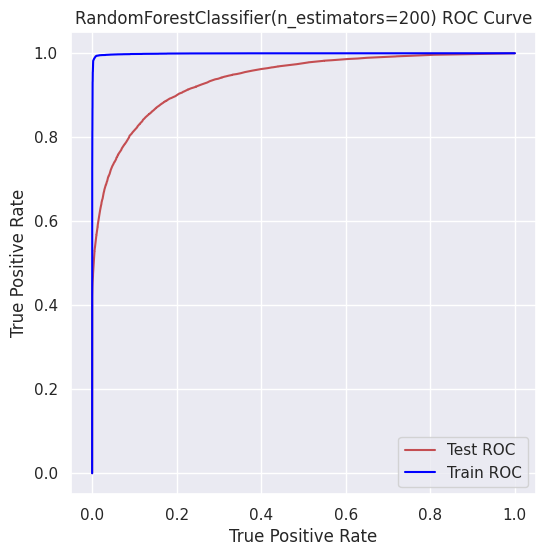

In [ ]:
depth = [10, 20, None]
estimators = [50,100,200]

for d in depth:
    for e in estimators:
        print('---------Train & Test scores : RFC model with n_estimators = {} and max_depth = {} ---------'.format(e, d))
        rfc_i = RandomForestClassifier(n_estimators = e, max_depth = d)
        rfc_i.fit(X_train, y_train)
        y_pred = rfc_i.predict(X_test)
        evaluation_block(rfc_i)
        plot_ROC(rfc_i)
        save_scores(rfc_i)

In [ ]:
results.sort_values('test_accuracy', ascending = False)

,model,train_accuracy,test_accuracy,train_ROC,test_ROC
22,"(DecisionTreeClassifier(max_features='sqrt', random_state=500974269), DecisionTreeClassifier(max...",0.9922,0.8722,0.9991,0.9378
21,"(DecisionTreeClassifier(max_features='sqrt', random_state=890845738), DecisionTreeClassifier(max...",0.9922,0.8720,0.9991,0.9365
13,"(DecisionTreeClassifier(max_features='sqrt', random_state=282791559), DecisionTreeClassifier(max...",0.9922,0.8716,0.9991,0.9373
20,"(DecisionTreeClassifier(max_features='sqrt', random_state=1622683246), DecisionTreeClassifier(ma...",0.9920,0.8714,0.9991,0.9354
18,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9048,0.8607,0.9773,0.9314
19,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9053,0.8607,0.9775,0.9323
17,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9048,0.8602,0.9772,0.9303
7,KNeighborsClassifier(n_neighbors=10),0.8548,0.8290,0.9325,0.8906
5,KNeighborsClassifier(n_neighbors=6),0.8682,0.8287,0.9472,0.8853
3,KNeighborsClassifier(n_neighbors=2),0.9091,0.8287,0.9781,0.8509


In [ ]:
result = permutation_importance(rfc, X_test, y_test, n_repeats=10)
perm_sorted_idx = result.importances_mean.argsort()

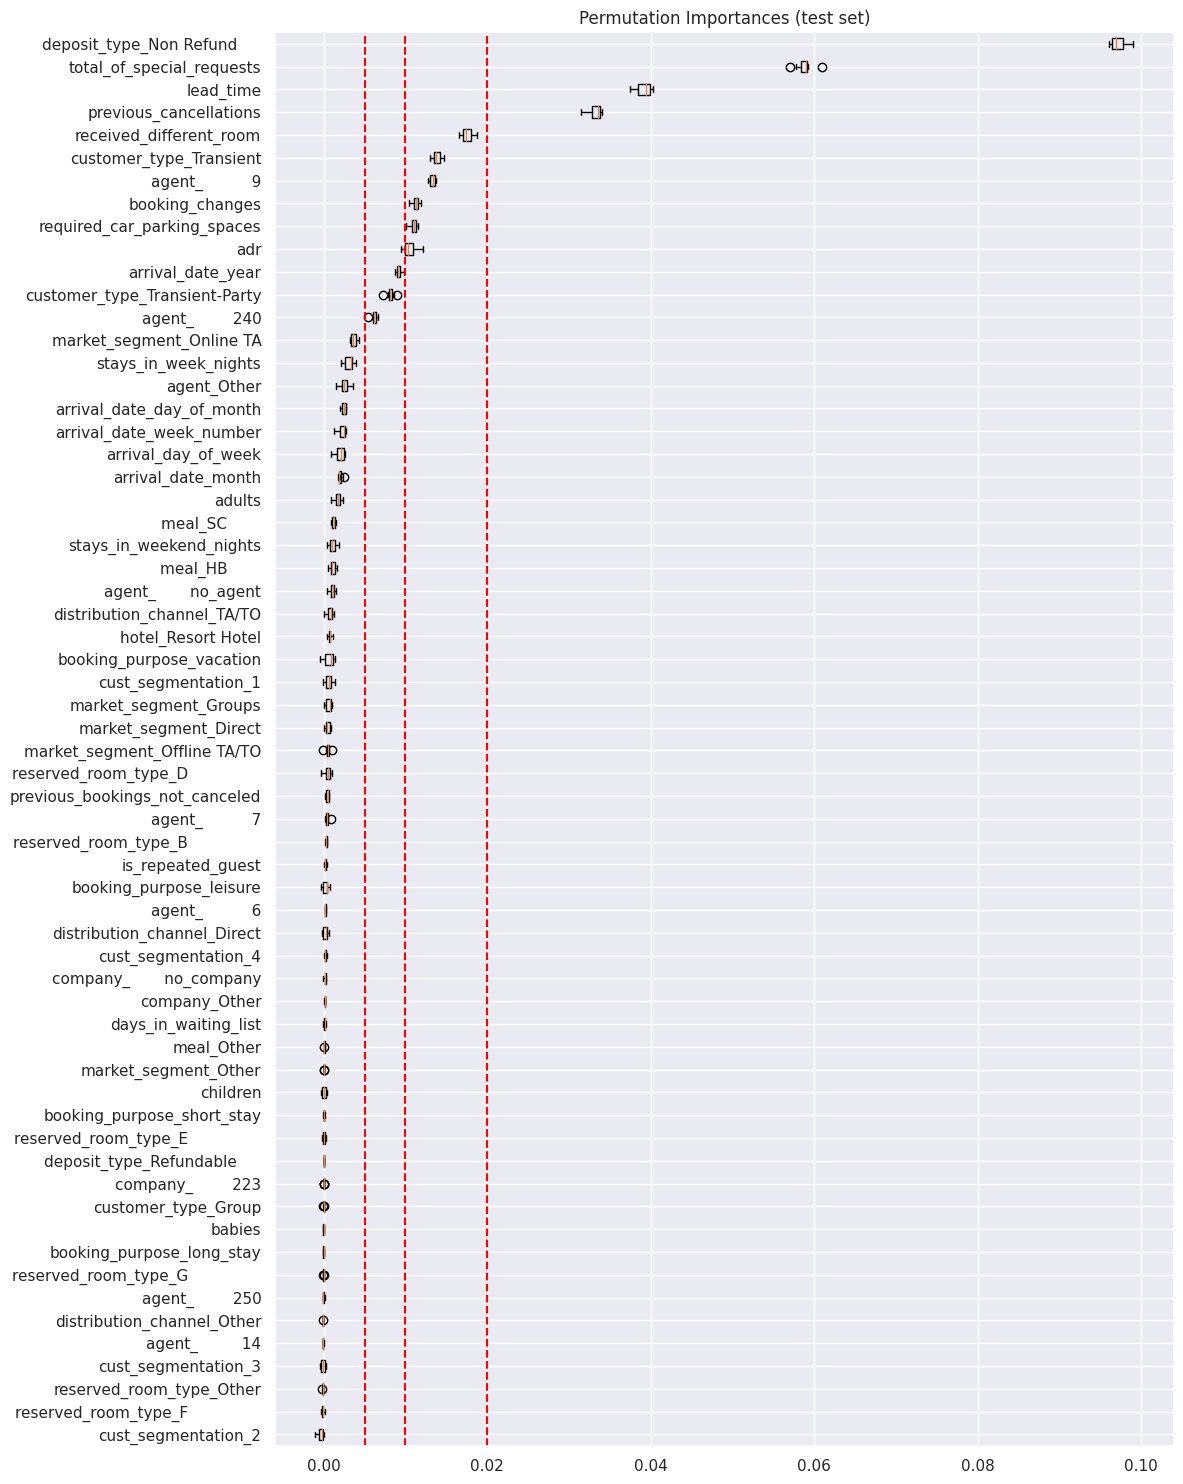

In [ ]:
fig, ax = plt.subplots(figsize=(12, 15))

ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, labels=X_dumm.columns[perm_sorted_idx])
[plt.axvline(x=i, linestyle='--', c = 'red') for i in [.005,.01,.02]]
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
# Choosing most important top 4,9,and 13 features.
top4_perm = X_dumm.columns[perm_sorted_idx][-4:]
top9_perm = X_dumm.columns[perm_sorted_idx][-9:]
top13_perm = X_dumm.columns[perm_sorted_idx][-13:]
top4_perm, top9_perm, top13_perm

(Index(['previous_cancellations', 'lead_time', 'total_of_special_requests',
        'deposit_type_Non Refund     '],
       dtype='object'),
 Index(['required_car_parking_spaces', 'booking_changes', 'agent_          9',
        'customer_type_Transient', 'received_different_room',
        'previous_cancellations', 'lead_time', 'total_of_special_requests',
        'deposit_type_Non Refund     '],
       dtype='object'),
 Index(['agent_        240', 'customer_type_Transient-Party',
        'arrival_date_year', 'adr', 'required_car_parking_spaces',
        'booking_changes', 'agent_          9', 'customer_type_Transient',
        'received_different_room', 'previous_cancellations', 'lead_time',
        'total_of_special_requests', 'deposit_type_Non Refund     '],
       dtype='object'))

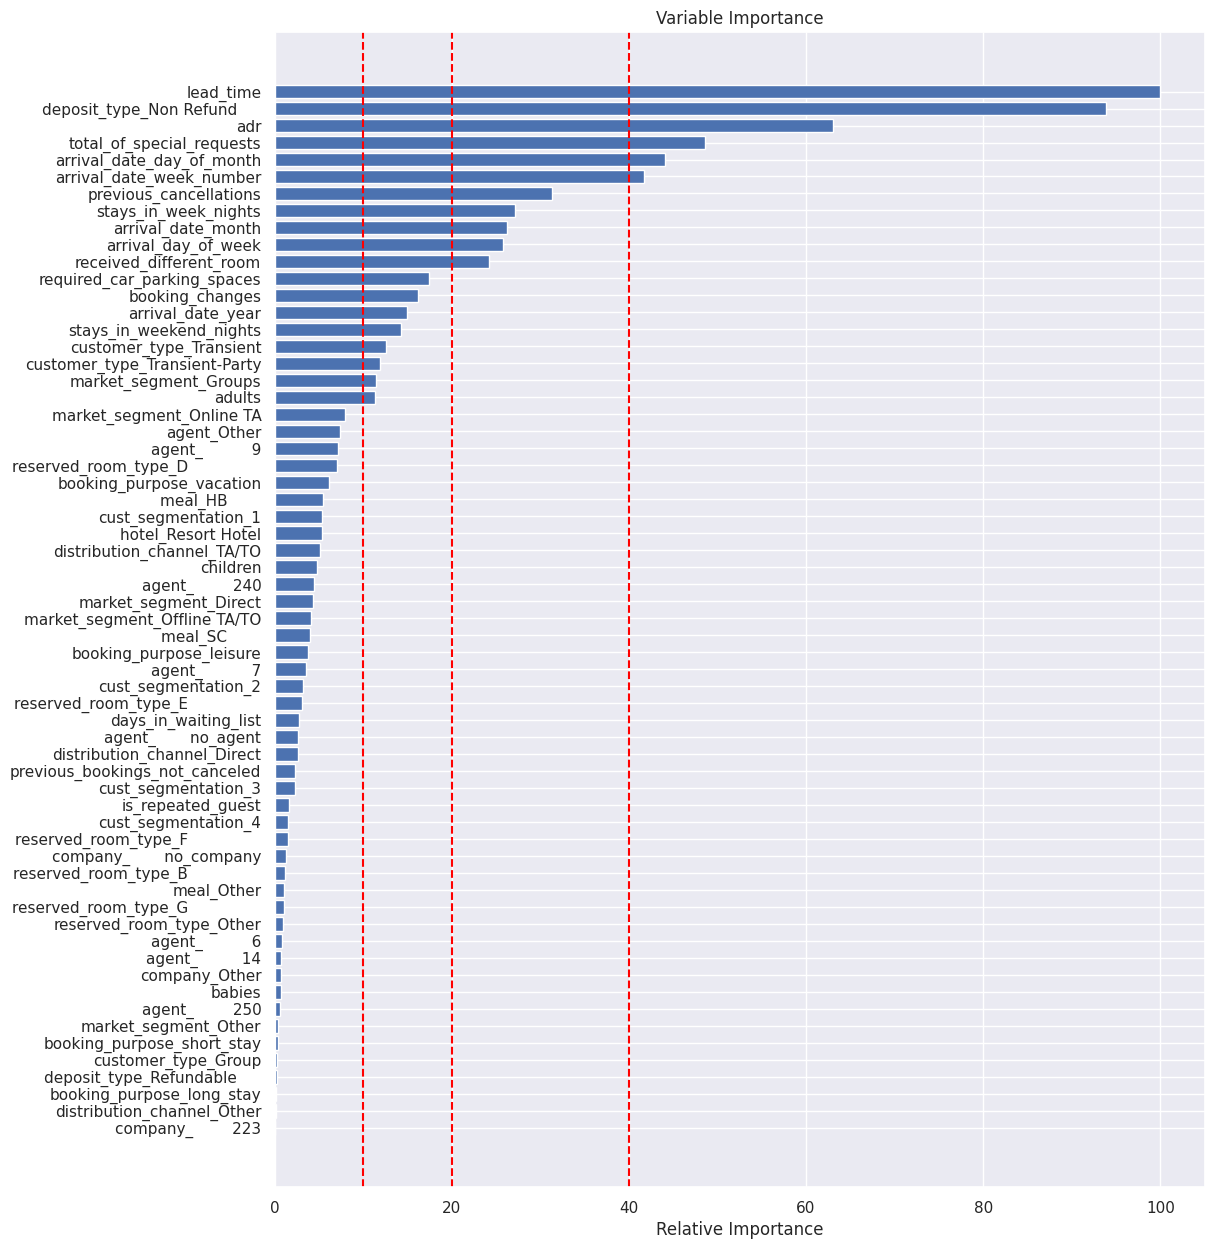

In [ ]:
feature_importance = rfc.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
feat_sorted_idx = np.argsort(feature_importance)

pos = np.arange(feat_sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,15))
plt.barh(pos, feature_importance[feat_sorted_idx], align='center')
[plt.axvline(x=i, linestyle='--', c = 'red') for i in [10,20,40]]
plt.yticks(pos, X_dumm.columns[feat_sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
# Choosing most important top 4,9,and 13 features.
top6_feat = X_dumm.columns[feat_sorted_idx][-6:]
top11_feat = X_dumm.columns[feat_sorted_idx][-11:]
top19_feat = X_dumm.columns[feat_sorted_idx][-19:]
top6_feat, top11_feat, top19_feat

(Index(['arrival_date_week_number', 'arrival_date_day_of_month',
        'total_of_special_requests', 'adr', 'deposit_type_Non Refund     ',
        'lead_time'],
       dtype='object'),
 Index(['received_different_room', 'arrival_day_of_week', 'arrival_date_month',
        'stays_in_week_nights', 'previous_cancellations',
        'arrival_date_week_number', 'arrival_date_day_of_month',
        'total_of_special_requests', 'adr', 'deposit_type_Non Refund     ',
        'lead_time'],
       dtype='object'),
 Index(['adults', 'market_segment_Groups', 'customer_type_Transient-Party',
        'customer_type_Transient', 'stays_in_weekend_nights',
        'arrival_date_year', 'booking_changes', 'required_car_parking_spaces',
        'received_different_room', 'arrival_day_of_week', 'arrival_date_month',
        'stays_in_week_nights', 'previous_cancellations',
        'arrival_date_week_number', 'arrival_date_day_of_month',
        'total_of_special_requests', 'adr', 'deposit_type_Non Refund

In [ ]:
least_feat = set().union(top6_feat, top4_perm)
mid_feat = set().union(top11_feat, top9_perm)
most_feat = set().union(top19_feat, top13_perm)

print('The Predictive features subsets have {}, {} respectively {} features.'.format(len(least_feat), len(mid_feat), len(most_feat)))

The Predictive features subsets have 7, 15 respectively 21 features.


In [ ]:
rfc1 = RandomForestClassifier(n_estimators = 200)
rfc4 = RandomForestClassifier(n_estimators = 200, max_depth = 20)

----------Random forest model on train set with 7 most important features-------
RandomForestClassifier(n_estimators=200)


<ipython-input-80-ed48d1772fea>:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = X_dumm[columns_set]


Train - Accuracy: 0.987
Test - Accuracy: 0.8295
Validation - Classification report
               precision    recall  f1-score   support

           0       0.83      0.91      0.87     22589
           1       0.82      0.68      0.75     13228

    accuracy                           0.83     35817
   macro avg       0.83      0.80      0.81     35817
weighted avg       0.83      0.83      0.83     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9981
Test - Area under ROC score: 0.8917


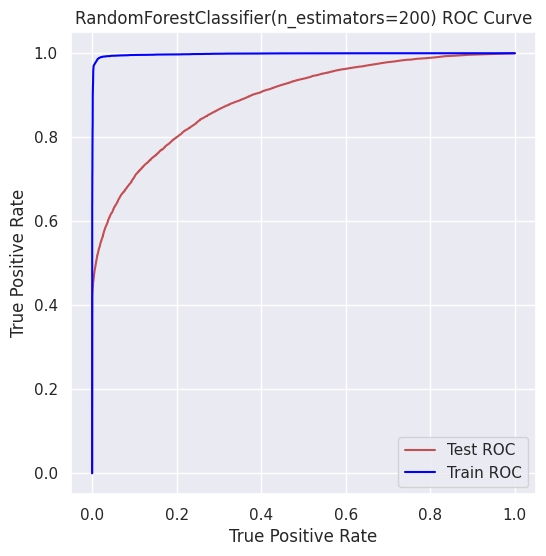

RandomForestClassifier(max_depth=20, n_estimators=200)
Train - Accuracy: 0.9357
Test - Accuracy: 0.828
Validation - Classification report
               precision    recall  f1-score   support

           0       0.82      0.94      0.87     22589
           1       0.85      0.64      0.73     13228

    accuracy                           0.83     35817
   macro avg       0.84      0.79      0.80     35817
weighted avg       0.83      0.83      0.82     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9893
Test - Area under ROC score: 0.8893


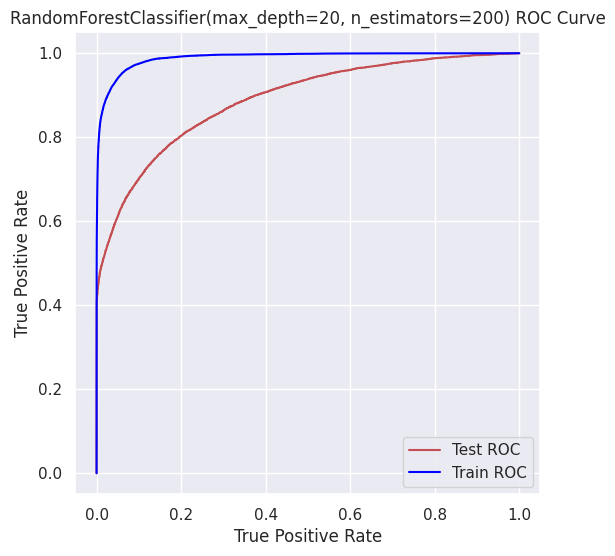

<ipython-input-80-ed48d1772fea>:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = X_dumm[columns_set]


----------Random forest model on train set with 15 most important features-------
RandomForestClassifier(n_estimators=200)
Train - Accuracy: 0.9911
Test - Accuracy: 0.8604
Validation - Classification report
               precision    recall  f1-score   support

           0       0.86      0.93      0.89     22623
           1       0.85      0.75      0.80     13194

    accuracy                           0.86     35817
   macro avg       0.86      0.84      0.85     35817
weighted avg       0.86      0.86      0.86     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9989
Test - Area under ROC score: 0.9271


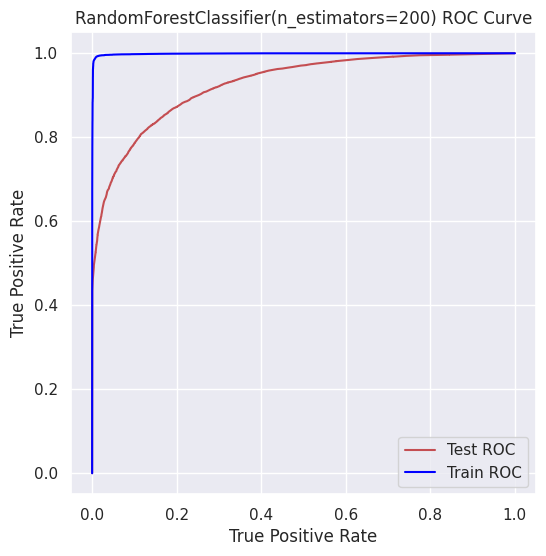

RandomForestClassifier(max_depth=20, n_estimators=200)
Train - Accuracy: 0.9213
Test - Accuracy: 0.8536
Validation - Classification report
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     22623
           1       0.88      0.70      0.78     13194

    accuracy                           0.85     35817
   macro avg       0.86      0.82      0.83     35817
weighted avg       0.86      0.85      0.85     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9866
Test - Area under ROC score: 0.9236


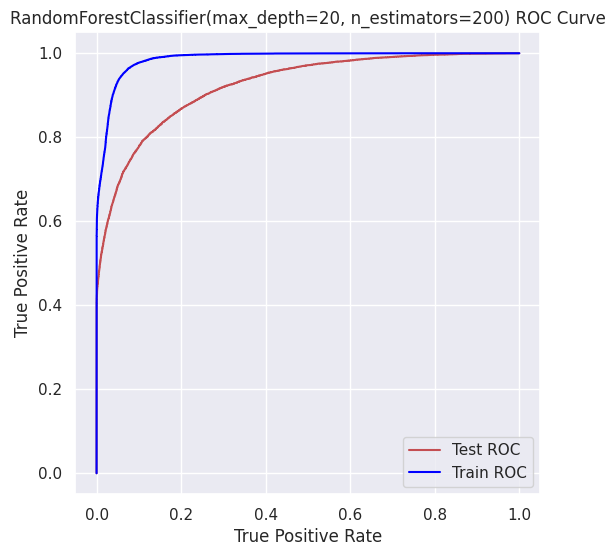

<ipython-input-80-ed48d1772fea>:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = X_dumm[columns_set]


----------Random forest model on train set with 21 most important features-------
RandomForestClassifier(n_estimators=200)
Train - Accuracy: 0.9919
Test - Accuracy: 0.8701
Validation - Classification report
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     22531
           1       0.87      0.77      0.81     13286

    accuracy                           0.87     35817
   macro avg       0.87      0.85      0.86     35817
weighted avg       0.87      0.87      0.87     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9991
Test - Area under ROC score: 0.9335


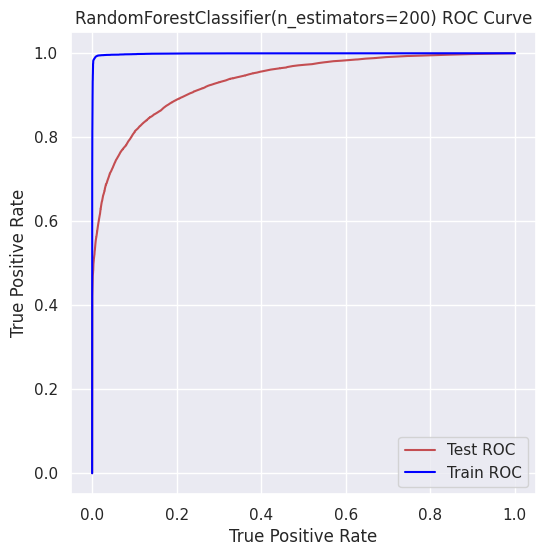

RandomForestClassifier(max_depth=20, n_estimators=200)
Train - Accuracy: 0.9252
Test - Accuracy: 0.8617
Validation - Classification report
               precision    recall  f1-score   support

           0       0.86      0.94      0.89     22531
           1       0.87      0.74      0.80     13286

    accuracy                           0.86     35817
   macro avg       0.86      0.84      0.85     35817
weighted avg       0.86      0.86      0.86     35817



<Figure size 900x900 with 0 Axes>

Train - Area under ROC score: 0.9853
Test - Area under ROC score: 0.9302


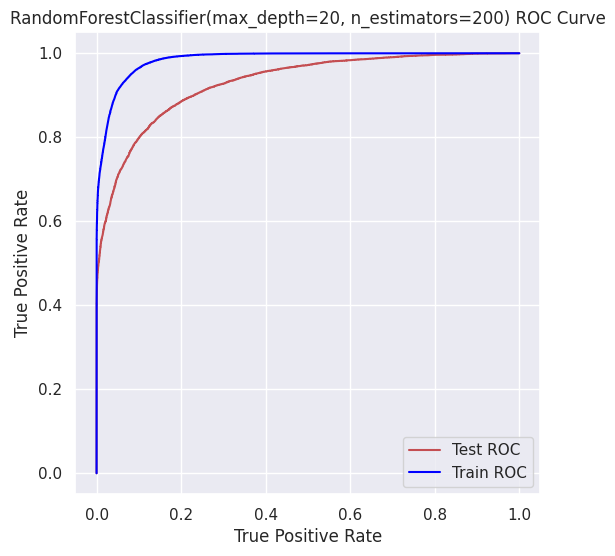

In [ ]:
# Because we need to alter the number of features in or X, X_train and X-test, we will create function
# so that the modifications on this variables can happen localy, and outside the scope of this function
# the data to remain unchanged.


def selecting_features():
    for columns_set in [least_feat, mid_feat, most_feat]:
        X = X_dumm[columns_set]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
        print('----------Random forest model on train set with {} most important features-------'.format(len(columns_set)))
        for rfc_model in [rfc1, rfc4]:
            print(rfc_model)
            rfc_model.fit(X_train, y_train)
            y_pred = rfc_model.predict(X_test)

            y_tr_pred = rfc_model.predict(X_train)

            train_acc = round(accuracy_score(y_train,y_tr_pred),4)
            test_acc = round(accuracy_score(y_test,y_pred),4)

            print("Train - Accuracy:", train_acc)
            print("Test - Accuracy:", test_acc)
            print('Validation - Classification report\n', classification_report(y_test,y_pred))
            plt.figure(figsize=(9,9))
            # plot_confusion_matrix(rfc_model, X_test, y_test, normalize='true', cmap = 'Blues')
            plt.show()

            y_pred_prob = rfc_model.predict_proba(X_test)[:,1]
            y_tr_pred_prob = rfc_model.predict_proba(X_train)[:,1]

            train_roc_score = round(roc_auc_score(y_train, y_tr_pred_prob),4)
            test_roc_score = round(roc_auc_score(y_test, y_pred_prob),4)

            print('Train - Area under ROC score: {}'.format(train_roc_score))
            print('Test - Area under ROC score: {}'.format(test_roc_score))

            fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_prob)
            fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_tr_pred_prob)
            plt.figure(figsize=(6,6))
            plt.plot(fpr_test, tpr_test, label = 'Test ROC', c = 'r')
            plt.plot(fpr_train, tpr_train, label = 'Train ROC', c = 'blue')
            plt.xlabel('True Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend()
            plt.title('{} ROC Curve'.format(rfc_model))
            plt.show()

            new_row = {'model':rfc_model,
               'train_accuracy': train_acc,
               'test_accuracy': test_acc,
               'train_ROC': train_roc_score,
               'test_ROC': test_roc_score}
            results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row

selecting_features()

In [ ]:
#let's check how the latest models(indexes 31 to 36) are compared to the rest in the top 15 scores
results.sort_values('test_accuracy', ascending = False).head(15)

,model,train_accuracy,test_accuracy,train_ROC,test_ROC
22,"(DecisionTreeClassifier(max_features='sqrt', random_state=500974269), DecisionTreeClassifier(max...",0.9922,0.8722,0.9991,0.9378
21,"(DecisionTreeClassifier(max_features='sqrt', random_state=890845738), DecisionTreeClassifier(max...",0.9922,0.8720,0.9991,0.9365
13,"(DecisionTreeClassifier(max_features='sqrt', random_state=282791559), DecisionTreeClassifier(max...",0.9922,0.8716,0.9991,0.9373
20,"(DecisionTreeClassifier(max_features='sqrt', random_state=1622683246), DecisionTreeClassifier(ma...",0.9920,0.8714,0.9991,0.9354
27,"(DecisionTreeClassifier(max_features='sqrt', random_state=446869832), DecisionTreeClassifier(max...",0.9919,0.8701,0.9991,0.9335
28,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9252,0.8617,0.9853,0.9302
19,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9053,0.8607,0.9775,0.9323
18,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9048,0.8607,0.9773,0.9314
25,"(DecisionTreeClassifier(max_features='sqrt', random_state=446869832), DecisionTreeClassifier(max...",0.9911,0.8604,0.9989,0.9271
17,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9048,0.8602,0.9772,0.9303


In [ ]:
results.sort_values('test_accuracy', ascending = False)


,model,train_accuracy,test_accuracy,train_ROC,test_ROC
22,"(DecisionTreeClassifier(max_features='sqrt', random_state=500974269), DecisionTreeClassifier(max...",0.9922,0.8722,0.9991,0.9378
21,"(DecisionTreeClassifier(max_features='sqrt', random_state=890845738), DecisionTreeClassifier(max...",0.9922,0.8720,0.9991,0.9365
13,"(DecisionTreeClassifier(max_features='sqrt', random_state=282791559), DecisionTreeClassifier(max...",0.9922,0.8716,0.9991,0.9373
20,"(DecisionTreeClassifier(max_features='sqrt', random_state=1622683246), DecisionTreeClassifier(ma...",0.9920,0.8714,0.9991,0.9354
27,"(DecisionTreeClassifier(max_features='sqrt', random_state=446869832), DecisionTreeClassifier(max...",0.9919,0.8701,0.9991,0.9335
28,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9252,0.8617,0.9853,0.9302
19,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9053,0.8607,0.9775,0.9323
18,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9048,0.8607,0.9773,0.9314
25,"(DecisionTreeClassifier(max_features='sqrt', random_state=446869832), DecisionTreeClassifier(max...",0.9911,0.8604,0.9989,0.9271
17,"(DecisionTreeClassifier(max_depth=20, max_features='sqrt',\n random_state=...",0.9048,0.8602,0.9772,0.9303


In [ ]:
best_model = RandomForestClassifier(n_estimators = 200)

In [ ]:
hotels.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'arrival_day_of_week', 'booking_purpose', 'received_different_room',
       'cust_segmentation'],
      dtype='object')

In [ ]:
initial_percentage_cols = ['hotel', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type','deposit_type', 'agent',
       'company','arrival_day_of_week', 'booking_purpose']

In [ ]:
y = hotels['is_canceled']

hotels_initial_perc = hotels.loc[:,initial_percentage_cols]
hotels_initial_perc.head().T

,0,1,2,3,4
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel
arrival_date_year,2015,2015,2015,2015,2015
arrival_date_month,7,7,7,7,7
arrival_date_week_number,27,27,27,27,27
arrival_date_day_of_month,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2
children,0.0,0.0,0.0,0.0,0.0
babies,0,0,0,0,0


In [ ]:
hotels_initial_perc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119389 entries, 0 to 119388
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119389 non-null  object 
 1   arrival_date_year               119389 non-null  int64  
 2   arrival_date_month              119389 non-null  int64  
 3   arrival_date_week_number        119389 non-null  int64  
 4   arrival_date_day_of_month       119389 non-null  int64  
 5   stays_in_weekend_nights         119389 non-null  int64  
 6   stays_in_week_nights            119389 non-null  int64  
 7   adults                          119389 non-null  int64  
 8   children                        119389 non-null  float64
 9   babies                          119389 non-null  int64  
 10  meal                            119389 non-null  object 
 11  market_segment                  119389 non-null  object 
 12  distribution_cha

In [ ]:
categ_features = ['hotel',  'meal','market_segment', 'distribution_channel',
       'reserved_room_type','deposit_type', 'agent','company', 'booking_purpose']

# Let's create the input:
for cat_feature in categ_features:
    feature = (hotels_initial_perc[cat_feature].unique())
    print(cat_feature, feature)

hotel ['Resort Hotel' 'City Hotel']
meal ['BB       ' 'Other' 'HB       ' 'SC       ']
market_segment ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Other' 'Groups']
distribution_channel ['Direct' 'Corporate' 'TA/TO' 'Other']
reserved_room_type ['Other' 'A               ' 'D               ' 'E               '
 'G               ' 'F               ' 'B               ']
deposit_type ['No Deposit     ' 'Refundable     ' 'Non Refund     ']
agent ['       no_agent' 'Other' '        240' '        250' '          9'
 '          6' '          1' '          7' '         14']
company ['       no_company' 'Other' '        223' '         40']
booking_purpose ['short_stay' 'business' 'vacation' 'leisure' 'long_stay']


In [ ]:
diction = {}
for cat_feature in categ_features:
    hotels_initial_perc[cat_feature] = hotels_initial_perc[cat_feature].str.strip()
    feature_values = (hotels_initial_perc[cat_feature].unique())
    diction[cat_feature] = feature_values

print(diction)

{'hotel': array(['Resort Hotel', 'City Hotel'], dtype=object), 'meal': array(['BB', 'Other', 'HB', 'SC'], dtype=object), 'market_segment': array(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO', 'Other',
       'Groups'], dtype=object), 'distribution_channel': array(['Direct', 'Corporate', 'TA/TO', 'Other'], dtype=object), 'reserved_room_type': array(['Other', 'A', 'D', 'E', 'G', 'F', 'B'], dtype=object), 'deposit_type': array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object), 'agent': array(['no_agent', 'Other', '240', '250', '9', '6', '1', '7', '14'],
      dtype=object), 'company': array(['no_company', 'Other', '223', '40'], dtype=object), 'booking_purpose': array(['short_stay', 'business', 'vacation', 'leisure', 'long_stay'],
      dtype=object)}


In [ ]:
booking_cols = hotels_initial_perc.drop(['arrival_day_of_week', 'arrival_date_week_number', 'booking_purpose'], axis=1 )\
            .columns

new_booking = {}
print('Entering a new booking')
for i in booking_cols:
    if i in categ_features:
        print('Select a value for ', i, 'from the following values: ', diction[i])
        new_booking[i] = input('Select a value: ')
        while new_booking[i] not in diction[i]:
            new_booking[i] = str(input('Wrong input. Select a value: '))
    else:
        print('Select a numerical value for ', i)
        new_booking[i] = int(input('Select a value: '))
    print('\n')

Entering a new booking
Select a value for  hotel from the following values:  ['Resort Hotel' 'City Hotel']
Select a value: Resort Hotel


Select a numerical value for  arrival_date_year
Select a value: 2091


Select a numerical value for  arrival_date_month
Select a value: 7


Select a numerical value for  arrival_date_day_of_month
Select a value: 12


Select a numerical value for  stays_in_weekend_nights
Select a value: 4


Select a numerical value for  stays_in_week_nights
Select a value: 5


Select a numerical value for  adults
Select a value: 2


Select a numerical value for  children
Select a value: 3


Select a numerical value for  babies
Select a value: 0


Select a value for  meal from the following values:  ['BB' 'Other' 'HB' 'SC']
Select a value: BB


Select a value for  market_segment from the following values:  ['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Other' 'Groups']
Select a value: Online TA


Select a value for  distribution_channel from the following values:  

In [ ]:
# Creating day_of_week and feature
projected_arrival = pd.to_datetime(str(new_booking['arrival_date_year'])+'-'\
                                               +str(new_booking['arrival_date_month'])+'-'\
                                               +str(new_booking['arrival_date_day_of_month']))

new_booking['arrival_day_of_week'] = projected_arrival.weekday()

new_booking['arrival_date_week_number'] = projected_arrival.isocalendar()[1]

# Creating booking_purpose feature
p = 'long_stay'

if (2 <= int(new_booking['stays_in_week_nights']) <= 15 and 1 <= int(new_booking['stays_in_weekend_nights']) <= 7):
    p = 'vacation'

if (0 <= int(new_booking['stays_in_week_nights']) <= 1 and 1 <= int(new_booking['stays_in_weekend_nights']) <= 2):
    p = 'leisure'

if (1 <= int(new_booking['stays_in_week_nights']) <= 5 and int(new_booking['stays_in_weekend_nights'] == 0)):
    p = 'business'

if (int(new_booking['stays_in_week_nights']) == 0 and int(new_booking['stays_in_weekend_nights'] == 0)):
    p = 'short_stay'

new_booking['booking_purpose'] = p

In [ ]:
new_booking

{'hotel': 'Resort Hotel',
 'arrival_date_year': 2091,
 'arrival_date_month': 7,
 'arrival_date_day_of_month': 12,
 'stays_in_weekend_nights': 4,
 'stays_in_week_nights': 5,
 'adults': 2,
 'children': 3,
 'babies': 0,
 'meal': 'BB',
 'market_segment': 'Online TA',
 'distribution_channel': 'Corporate',
 'is_repeated_guest': 0,
 'previous_cancellations': 1,
 'previous_bookings_not_canceled': 0,
 'reserved_room_type': 'A',
 'deposit_type': 'Refundable',
 'agent': '240',
 'company': '40',
 'arrival_day_of_week': 3,
 'arrival_date_week_number': 28,
 'booking_purpose': 'vacation'}

In [ ]:
hotels_initial_perc = hotels_initial_perc.append(new_booking, ignore_index = True)

<ipython-input-95-2d96e38ae396>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels_initial_perc = hotels_initial_perc.append(new_booking, ignore_index = True)


In [ ]:
hotels_initial_perc.tail()

,hotel,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,deposit_type,agent,company,arrival_day_of_week,booking_purpose
119385,City Hotel,2017,8,35,31,2,5,3,0.0,0,...,TA/TO,0,0,0,E,No Deposit,9,no_company,3,vacation
119386,City Hotel,2017,8,35,31,2,5,2,0.0,0,...,TA/TO,0,0,0,D,No Deposit,9,no_company,3,vacation
119387,City Hotel,2017,8,35,31,2,5,2,0.0,0,...,TA/TO,0,0,0,A,No Deposit,Other,no_company,3,vacation
119388,City Hotel,2017,8,35,29,2,7,2,0.0,0,...,TA/TO,0,0,0,A,No Deposit,9,no_company,1,vacation
119389,Resort Hotel,2091,7,28,12,4,5,2,3.0,0,...,Corporate,0,1,0,A,Refundable,240,40,3,vacation


In [ ]:
X_init = pd.get_dummies(hotels_initial_perc, drop_first = True)

booking_w_dummy = X_init.tail(1)

X_init = X_init.drop(X_init.tail(1).index)

X_init.shape, y.shape, booking_w_dummy.shape

((119389, 48), (119389,), (1, 48))

In [ ]:
best_model.fit(X_init, y)

RandomForestClassifier(n_estimators=200)

In [ ]:
booking_prediction = best_model.predict(booking_w_dummy)
print('Customer is likely to cancel the booking' if booking_prediction[0]==1 else 'Customer is likely to keep the booking')

Customer is likely to cancel the booking


In [ ]:
y_pred_prob = best_model.predict_proba(booking_w_dummy)[:,1]
print('Customer is {} % likely to cancel the booking'.format(round(y_pred_prob[0]*100,4)))

Customer is 62.3 % likely to cancel the booking


In [ ]:
# Saving model


In [ ]:
# Saving data to final folder
